## Tutorial 07 - Non linear Elliptic problem
**_Keywords: DEIM, POD-Galerkin_**

### 1. Introduction

In this tutorial, we consider a non linear elliptic problem in a two-dimensional spatial domain $\Omega=(0,1)^2$.

![mesh](data/mesh.png)

We impose a homogeneous Dirichlet condition on the boundary $\partial\Omega$. The source term is characterized by the following expression
$$
g(\boldsymbol{x}; \boldsymbol{\mu}) = 100\sin(2\pi x_0)cos(2\pi x_1) \quad \forall \boldsymbol{x} = (x_0, x_1) \in \Omega.
$$

This problem is characterized by two parameters. The first parameter $\mu_0$ controls the strength of the sink term and the second parameter $\mu_1$ the strength of the nonlinearity. The range of the two parameters is the following:
$$
\mu_0,\mu_1\in[0.01,10.0]
$$
The parameter vector $\boldsymbol{\mu}$ is thus given by
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
on the parameter domain
$$
\mathbb{P}=[0.01,10]^2.
$$


In order to obtain a faster approximation of the problem, we pursue a model reduction by means of a POD-Galerkin reduced order method. In order to preserve the affinity assumption the discrete empirical interpolation method will be used on the forcing term $g(\boldsymbol{x}; \boldsymbol{\mu})$.



### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the solution in the domain $\Omega$.

The strong formulation of the parametrized problem is given by: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})$ such that

$$ -\nabla^2u(\boldsymbol{\mu})+\frac{\mu_0}{\mu_1}(\exp\{\mu_1u(\boldsymbol{\mu})\}-1)=g(\boldsymbol{x}; \boldsymbol{\mu})$$
<br>
    
The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)+c\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in H_1(\Omega) : v|_{\partial\Omega}=0\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized bilinear form $c(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$c(u, v;\boldsymbol{\mu})=\mu_0\int_{\Omega} \frac{1}{\mu_1}\big(\exp\{\mu_1u\} - 1\big)v \ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu})= \int_{\Omega}g(\boldsymbol{x}; \boldsymbol{\mu})v \ d\boldsymbol{x}.$$

The output of interest $s(\boldsymbol{\mu})$ is given by
$$s(\boldsymbol{\mu}) = \int_{\Omega} v \ d\boldsymbol{x}$$
is computed for each $\boldsymbol{\mu}$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

### 3. Affine Decomposition 

For this problem the affine decomposition is straightforward:
$$a(u,v;\boldsymbol{\mu})=\underbrace{1}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)},$$
$$c(u,v;\boldsymbol{\mu})=\underbrace{\mu_0}_{\Theta^{c}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\frac{1}{\mu_1}\big(\exp\{\mu_1u\} - 1\big)v \ d\boldsymbol{x}}_{c_0(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{100}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Omega}\sin(2\pi x_0)cos(2\pi x_1)v \ d\boldsymbol{x}}_{f_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class NonlinearElliptic(NonlinearEllipticProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$, $\Theta^{c}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):
```
and the bilinear forms $a_*(u, v)$, $c_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
@DEIM("online", basis_generation="Greedy")
@ExactParametrizedFunctions("offline")
class NonlinearElliptic(NonlinearEllipticProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        NonlinearEllipticProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.du = TrialFunction(V)
        self.u = self._solution
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # Store the forcing term expression
        self.f = Expression("sin(2*pi*x[0])*sin(2*pi*x[1])", element=self.V.ufl_element())
        # Customize nonlinear solver parameters
        self._nonlinear_solver_parameters.update({
            "linear_solver": "mumps",
            "maximum_iterations": 20,
            "report": True
        })

    # Return custom problem name
    def name(self):
        return "NonlinearEllipticDEIM"

    # Return theta multiplicative terms of the affine expansion of the problem.
    @compute_theta_for_derivatives
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 1.#mu[0]
            return (theta_a0,)
        elif term == "c":
            theta_c0 = mu[0]
            return (theta_c0,)
        elif term == "f":
            theta_f0 = 100.
            return (theta_f0,)
        elif term == "s":
            theta_s0 = 1.0
            return (theta_s0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    @assemble_operator_for_derivatives
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            du = self.du
            a0 = inner(grad(du), grad(v)) * dx
            return (a0,)
        elif term == "c":
            u = self.u
            mu = self.mu
            c0 = (exp(mu[1] * u) - 1) / mu[1] * v * dx
            return (c0,)
        elif term == "f":
            f = self.f
            f0 = f * v * dx
            return (f0,)
        elif term == "s":
            s0 = v * dx
            return (s0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1)]
            return (bc0,)
        elif term == "inner_product":
            du = self.du
            x0 = inner(grad(du), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")


# Customize the resulting reduced problem
@CustomizeReducedProblemFor(NonlinearEllipticProblem)
def CustomizeReducedNonlinearElliptic(ReducedNonlinearElliptic_Base):
    class ReducedNonlinearElliptic(ReducedNonlinearElliptic_Base):
        def __init__(self, truth_problem, **kwargs):
            ReducedNonlinearElliptic_Base.__init__(self, truth_problem, **kwargs)
            self._nonlinear_solver_parameters.update({
                "report": True,
                "line_search": "wolfe"
            })

    return ReducedNonlinearElliptic

## 4. Main program

### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/square.xml")
subdomains = MeshFunction("size_t", mesh, "data/square_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/square_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the NonlinearElliptic class

In [5]:
problem = NonlinearElliptic(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.1, 10.0), (0.1, 10.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(8, DEIM=8)
reduction_method.set_tolerance(0, DEIM=0)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(100, DEIM=100)
reduced_problem = reduction_method.offline()

=                     DEIM preprocessing phase begins for                      =
=   { v_0 * (-1 + exp(f_9 * f_14)) / f_14 } * dx(<Mesh #0>[everywhere], {}),   =
=                                    where                                     =
=                                 f_14 = mu_1                                  =
=f_9 = solution of NonlinearEllipticDEIM (exact problem decorator: False, component: (None,))=
=               with id 49fc90be369b6ead57691b159f98bb7ecf8d1031               =

:::::::::::::::::::::::::::::::::::: DEIM 0 ::::::::::::::::::::::::::::::::::::
evaluate parametrized expression at mu = (3.1867792317416157, 6.993800539273049)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.359096e+00
  2 SNES Function norm 1.221942e+00
  3 SNES Function norm 1.098013e+00
  4 SNES Function norm 8.876467e-01
  5 SNES Function norm 8.480006e-01
  6 SNES Function norm 2.205764e-01
  7 SNES Function norm 2.594496e-02
  8 SNES Function norm 4.416342e-04
  9 SNES Func

#### 4.5.2 Train PINN

Given a training set $\Xi_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(N_\text{PINN})})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $u^{NN}(\boldsymbol{\mu})$ for the reduced order equations dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(\Xi_{PINN}; W) = \frac{1}{N_\text{PINN}} \sum_{i=1}^{N_\text{PINN}} \|A(\boldsymbol{\mu^{(i)}}) u^{NN}(\boldsymbol{\mu}^{(i)}; W) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)}) + \boldsymbol{c}(\boldsymbol{\mu}^{(i)})\|_2^2$$

over $W$, where for a given $\boldsymbol{\mu}$, $A(\boldsymbol{\mu})$ is the assembled reduced matrix corresponding to the bilinear form $a$ and $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled reduced vector corresponding to the linear form $f$, and $\boldsymbol{c}(\boldsymbol{\mu})$ is a vector corresponding to the nonlinear form $c$.

In [8]:
# build matrices for computing DEIM
selected_indices = sorted([idx[0] for idx in problem.DEIM_approximations['c'][0].interpolation_locations.get_dofs_list()])
U = np.array(problem._assemble_operator_DEIM('c')).T
P = []
for idx in selected_indices:
    new_column = np.zeros(U.shape[0])
    new_column[idx] = 1
    P.append(new_column)
P = np.array(P).T
PtUinv = np.linalg.inv(P.T @ U)

In [9]:
selected_indices = sorted([idx[0] for idx in problem.DEIM_approximations['c'][0].interpolation_locations.get_dofs_list()])
dx_test = torch.tensor(np.array(assemble(problem.v*dx))[selected_indices].reshape(-1, 1))
ones_tensor = torch.ones_like(dx_test)

def DEIM_nonlinearity(u, mu):
    """
    u: torch.tensor with shape (reduced order dimension, number of samples)
    mu: torch.tensor with shape (number of samples, number of parameters)
    """
    res = mu[:, 0].view(1, -1) / mu[:, 1].view(1, -1) * (torch.exp(mu[:, 1].view(1, -1) * torch.minimum(u, 20*ones_tensor)) - 1)
    return torch.matmul(torch.tensor(PtUinv[:, :]), dx_test * res)

In [10]:
input_normalization_pinn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pinn = Normalization.MinMaxNormalization()

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=60)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn, DEIM_func_c=DEIM_nonlinearity)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=60000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [11]:
pinn_trainer.train()

  0%|          | 0/60000 [00:00<?, ?it/s]

Operator 'c' not implemented. Continuing without operator 'c'...
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 'c' not implemented. Continuing without operator 'c'...
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 's' not implemented. Continuing without operator 's'...


100%|██████████| 60000/60000 [01:17<00:00, 769.50it/s, Loss(training)=0.013] 


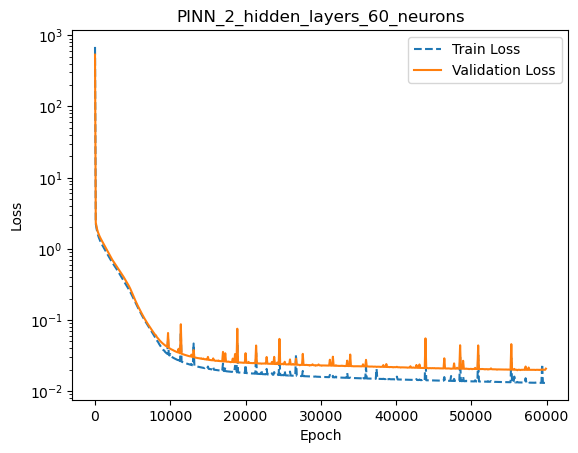

In [12]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.3 Train PDNN

Given a training set $\Xi_{PDNN} = ((\boldsymbol{\mu}^{(1)}, u^{\text{HF}}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(N_\text{PDNN})}, u^{\text{HF}}(\boldsymbol{\mu}^{(N_\text{PDNN})})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(\Xi_{PDNN}; W) = \frac{1}{N_\text{PDNN}} \sum_{i=1}^{N_\text{PDNN}} \|u^{NN}(\boldsymbol{\mu}^{(i)}; W) - U^T u^{\text{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, the quantity $U^T u^{\text{HF}}(\boldsymbol{\mu})$ is the projection of the high fidelity solution $u^{\text{HF}}(\boldsymbol{\mu})$ onto the reduced order space.

In [13]:
input_normalization_pdnn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.MinMaxNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer, scheduler,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [14]:
pdnn_trainer.train()

100%|██████████| 10000/10000 [00:07<00:00, 1261.48it/s, Loss(training)=1.01e-5]


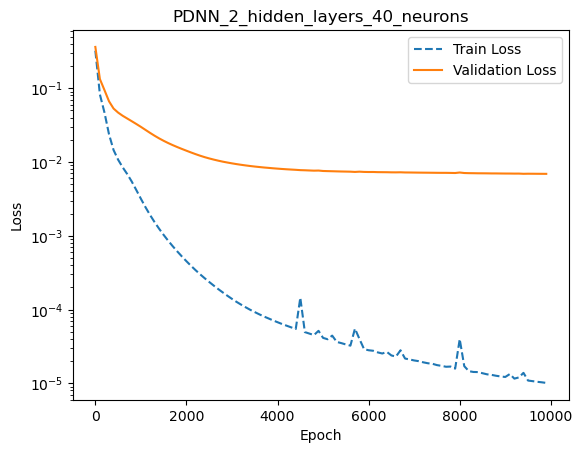

In [15]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $N_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(\Xi_{PINN}, \Xi_{PDNN}; W) = L_{PINN}(\Xi_{PINN}; W) + \omega L_{PDNN}(\Xi_{PDNN}; W)$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [16]:
input_normalization_prnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_prnn = Normalization.StandardNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer, scheduler,
    input_normalization_prnn, num_epochs=1000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [17]:
prnn_trainer.train()

  0%|          | 0/1000 [00:00<?, ?it/s]

Operator 'c' not implemented. Continuing without operator 'c'...
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 'c' not implemented. Continuing without operator 'c'...
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 's' not implemented. Continuing without operator 's'...


100%|██████████| 1000/1000 [00:01<00:00, 723.79it/s, Loss(training)=0.522]


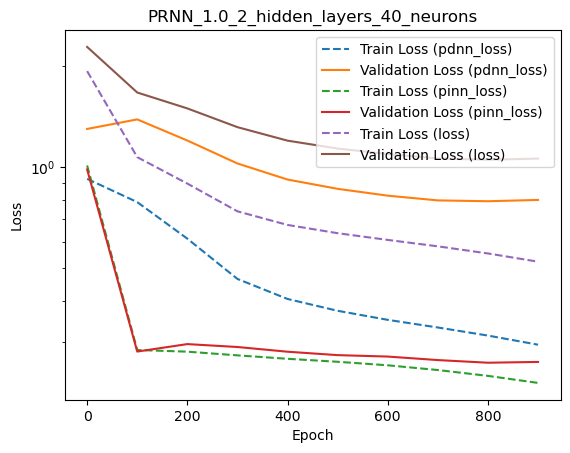

In [18]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [19]:
np.random.seed(0)

reduction_method.initialize_testing_set(100, DEIM=60)
test_set_mu = torch.tensor(reduction_method.testing_set)
online_mu = tuple(np.array(reduction_method.testing_set)[0, :])

#### 4.6.2 PINN Error Analysis

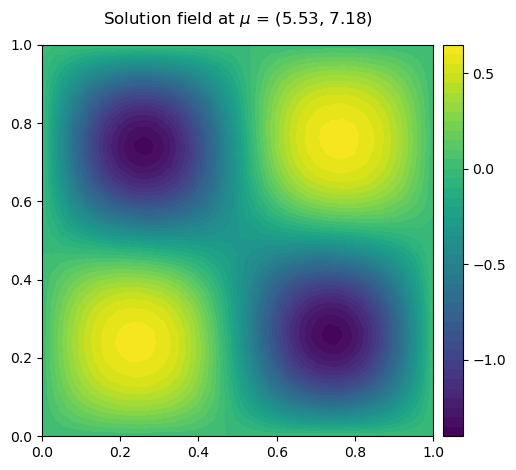

In [20]:
ErrorAnalysis.plot_solution(
    pinn_net, online_mu, input_normalization_pinn, output_normalization_pinn
)

In [21]:
errors = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_set_mu, input_normalization_pinn, output_normalization_pinn, relative=True
)

0:  |F(x)| = 3.70413; step 0.315498
1:  |F(x)| = 2.93906; step 0.2013
2:  |F(x)| = 1.17851; step 1
3:  |F(x)| = 0.19018; step 1
4:  |F(x)| = 0.00745998; step 1
5:  |F(x)| = 1.81814e-05; step 1
6:  |F(x)| = 6.20902e-07; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 3.18176; step 0.406551
1:  |F(x)| = 1.05961; step 1
2:  |F(x)| = 0.153865; step 1
3:  |F(x)| = 0.00518163; step 1
4:  |F(x)| = 5.12632e-05; step 1
5:  |F(x)| = 1.38849e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 3.59002; step 0.338434
1:  |F(x)| = 2.59376; step 0.268183
2:  |F(x)| = 0.735586; step 1
3:  |F(x)| = 0.0896442; step 1
4:  |F(x)| = 0.00186181; step 1
5:  |F(x)| = 8.03241e-06; step 1
6:  |F(x)| = 1.50547e-07; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 3.67382; step 0.314552
1:  |F(x)| = 1.61547; step 0.492105
2:  |F(x)| = 0.0517649; step 1
3:  |F(x)| = 0.000949155; step 1
4:  |F(x)| = 1.0839e-05; step 1
5:  |F(x)| = 4.0625e-07; step 1
scipy solver converged in 7 it

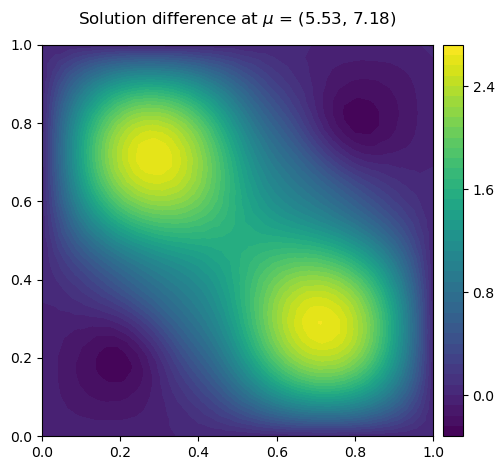

In [22]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, online_mu, input_normalization_pinn, output_normalization_pinn, colorbar=True
)

#### 4.6.3 PDNN Error Analysis

In [23]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_set_mu, input_normalization_pdnn, output_normalization_pdnn, relative=True
)

################################## PDNN N = 8 ##################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.00011650037215078926	0.00014216148644497861	3.218670499948375e-05
mean	0.0008726215872387551	0.0040922044593476765	0.003435181468740159
max	0.02543420622296407	0.025433270366619253	0.011465715065881626


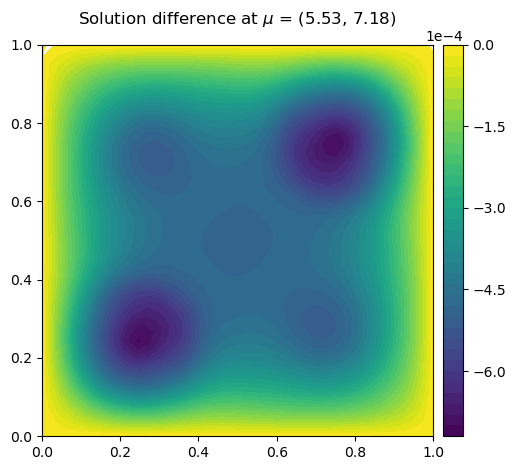

In [24]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, online_mu, input_normalization_pdnn, output_normalization_pdnn
)

#### 4.6.4 PRNN Error Analysis

In [25]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_set_mu, input_normalization_prnn, output_normalization_prnn, relative=False
)

################################ PRNN_1.0 N = 8 ################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.03100834853667143	0.03042124903554371	0.00016351528179498598
mean	0.5796899522975402	0.5837624846011639	0.016676538352034066
max	1.5047076108739923	1.5067971024339977	0.05460762465640748


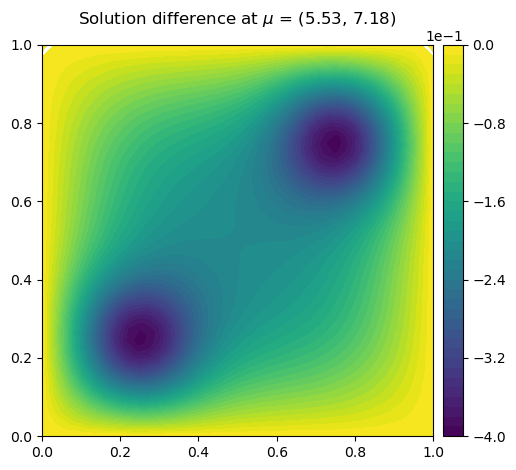

In [26]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, online_mu, input_normalization_prnn, output_normalization_prnn
)

#### 4.6.5 Neural Network Error Comparison

In [27]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_set_mu, input_normalizations, output_normalizations, relative=False
)

#####################################################################################
Mean Error for 8 Basis Functions
Network		NN-HF			NN-RO			RO-HF
pinn_net	4.459022021012512	4.446339873881726	0.016676538352034066
pdnn_net	0.004407254268877243	0.02009099502399263	0.016676538352034066
prnn_net	0.5796899522975402	0.5837624846011639	0.016676538352034066
#####################################################################################
